<a href="https://colab.research.google.com/github/Iramuk-ganh/rl/blob/main/sarsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week3_model_free/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../xserver-common_2%3a1.19.6-1ubuntu4.10_all.deb ...
Unpacking xserver-common (2:1.19.6-1ubuntu4.10) over (2:1.19.6-1ubuntu4.9) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xserver-common (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from collections import defaultdict
import random
import math
import numpy as np

In [ ]:
class QLearningAgent:
  def __init__(self, alpha, epsilon, discount, get_legal_actions):
    self.get_legal_actions = get_legal_actions
    self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
    self.alpha = alpha
    self.epsilon = epsilon
    self.discount = discount

  def get_qvalue(self, state, action):
    return self._qvalues[state][action]

  def set_qvalue(self, state, action, value):
    self._qvalues[state][action] = value



  def get_value(self, state):
    possible_actions = self.get_legal_actions(state)
   
    if len(possible_actions) == 0:
      return 0.0

    else:
      #for i in range(len(possible_actions)):
       # if self.get_qvalue(state, possible_actions[0])>value:
      #    value = self.get_qvalue(state, possible_actions[0])
      #return value
      value  = np.max([self.get_qvalue(state, i) for i in possible_actions])
      return value

  def update(self, state, action, reward, next_state):
    gamma = self.discount
    learning_rate = self.alpha

    #Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))

    q_value = (1-learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + (gamma * self.get_value(next_state)))
    self.set_qvalue(state, action, q_value)

  def get_best_action(self, state):
    #Compute the best action to take in a state (using current q-values)
    possible_actions = self.get_legal_actions(state)

    # If there are no legal actions, return None
    if len(possible_actions) == 0:
      return None
    list_of_qvalues = [self.get_qvalue(state, action) for action in possible_actions]
    best_action_index = np.argmax(list_of_qvalues)
    return possible_actions[best_action_index]

  def get_action(self, state):
    possible_actions = self.get_legal_actions(state)
    best_action = self.get_best_action(state)

    if len( possible_actions) == 0:
      return None
    
    epsilon = self.epsilon
    choice = np.random.choice([0,1], p=[epsilon, 1-epsilon])
    if choice:
      chosen_action = best_action
    else:
      chosen_action = np.random.choice(possible_actions)
    return chosen_action

Returns Vpi for current state under epsilon-greedy policy:

         
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}
      

In [ ]:
class EVSarsaAgent(QLearningAgent):
  def get_value(self, state):
    epsilon = self.epsilon
    possible_actions = self.get_legal_actions(state)

    if len(possible_actions) == 0:
      return 0.0

    state_value = 0
    for action in possible_actions:
      if action == self.get_best_action(state):
        state_value += ((1-epsilon)+epsilon/len(possible_actions)) * self.get_qvalue(state, action)
      
      else:
        state_value += (epsilon/len(possible_actions)) * self.get_qvalue(state, action)
           
    return state_value

In [ ]:
import gym
import gym.envs.toy_text

In [ ]:
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n
print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [ ]:
# Our cliffworld has one difference from what's on the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [ ]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [ ]:
agent_sarsa = EVSarsaAgent(alpha = 0.25, epsilon = 0.25, discount = 0.99, get_legal_actions = lambda s: range(n_actions))
agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [ ]:
from IPython.display import clear_output
import pandas as pd

EVSARSA mean reward = -33.38
QLEARNING mean reward = -66.5


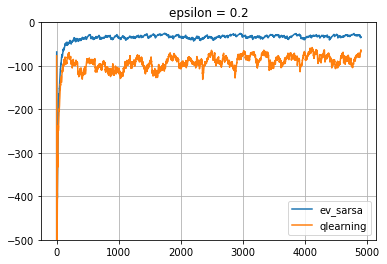

In [ ]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [ ]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [ ]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 >  >  v  v  v  v  v  >  v  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
from submit import submit_sarsa
submit_sarsa(rewards_ql, rewards_sarsa, 'yonghangaashma7@gmail.com', 'msjr3HPSNxSm59ML')

Submitted to Coursera platform. See results on assignment page!
